In [1]:
import yaml
import itertools
import time
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from tabulate import tabulate
from data import get_data
from pinn import PINN_experiment
from modules import Model
from sklearn.metrics import mean_squared_error

In [ ]:

#Load hyperparameters from YAML file
with open("hyperparameters.yml", "r") as file:
    config = yaml.safe_load(file)
hyperparams = config["hyperparameters"]

#Create dropdown widgets for user selection
layers_dropdown = widgets.Dropdown(options=hyperparams["layers"], description="Layers:")
neurons_dropdown = widgets.Dropdown(options=hyperparams["neurons"], description="Neurons:")
samples_dropdown = widgets.Dropdown(options=hyperparams["training_samples"], description="Samples:")
noise_dropdown = widgets.Dropdown(options=hyperparams["noise_level"], description="Noise:")
iterations_dropdown = widgets.Dropdown(options=hyperparams["iterations"], description="Iterations:")
run_button = widgets.Button(description="Run Experiment")
output = widgets.Output()

#Define function to run the experiment
def run_experiment(layers, neurons, samples, noise, iterations):
    with output:
        output.clear_output()
        print(f"Running experiment with Layers={layers}, Neurons={neurons}, Samples={samples}, Noise={noise}, Iterations={iterations}")

        # Load data
        data = get_data()
        x_test, y_test, *_ = data

        # Start timing
        start_time = time.time()
        PINN_experiment(data, [noise], verbose=False, rerun=True)
        end_time = time.time()

        # Load RMSE from saved results instead of recalculating
        all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
        rmse = all_results[0][-1]  # Extract the last stored RMSE

        print(f"\nResults:")
        print(f" - Loaded RMSE from training: {rmse:.6f}")
        print(f" - Running Time: {end_time - start_time:.2f} seconds")

        # Generate contour plots for actual vs predicted solutions
        model = Model()
        x_test_tensor = torch.tensor(x_test).double()
        predictions = model.forward(x_test_tensor).detach().numpy()

        x_values = np.unique([x[0] for x in x_test])
        t_values = np.unique([x[1] for x in x_test])
        Y_actual = np.array(y_test).reshape(len(t_values), len(x_values))
        Y_pred = predictions.reshape(len(t_values), len(x_values))

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        c1 = ax[0].contourf(t_values, x_values, Y_actual.T, cmap="coolwarm", levels=50)
        fig.colorbar(c1, ax=ax[0])
        ax[0].set_title("Burgers' Solution $u(t,x)$")
        ax[0].set_xlabel("t (s)")
        ax[0].set_ylabel("x")

        c2 = ax[1].contourf(t_values, x_values, Y_pred.T, cmap="coolwarm", levels=50)
        fig.colorbar(c2, ax=ax[1])
        ax[1].set_title("Predicted $\\hat{u}(t,x)$")
        ax[1].set_xlabel("t (s)")
        ax[1].set_ylabel("x")

        plt.tight_layout()
        plt.show()

        # Generate heatmap of error
        error = np.abs(Y_actual - Y_pred)
        error = np.nan_to_num(error, nan=0.0, posinf=np.max(error[np.isfinite(error)]), neginf=0.0)

        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(error.T, cmap="coolwarm", cbar=True, square=True)

        num_x_ticks = 10  
        num_t_ticks = 10  

        ax.set_xticks(np.linspace(0, len(t_values) - 1, num_t_ticks))  
        ax.set_xticklabels(np.round(np.linspace(t_values.min(), t_values.max(), num_t_ticks), 2)) 

        ax.set_yticks(np.linspace(0, len(x_values) - 1, num_x_ticks))
        ax.set_yticklabels(np.round(np.linspace(x_values.min(), x_values.max(), num_x_ticks), 2)) 

        plt.xlabel("t (s)")
        plt.ylabel("x")
        plt.title("Heatmap of Prediction Error")
        plt.show()

# Define button click function
def on_button_click(b):
    run_experiment(layers_dropdown.value, neurons_dropdown.value, samples_dropdown.value, noise_dropdown.value, iterations_dropdown.value)

# Bind button to function
run_button.on_click(on_button_click)

# Display UI components
display(widgets.VBox([layers_dropdown, neurons_dropdown, samples_dropdown, noise_dropdown, iterations_dropdown, run_button, output]))


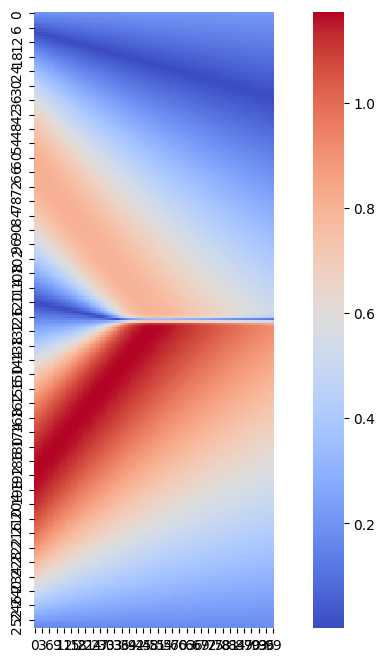

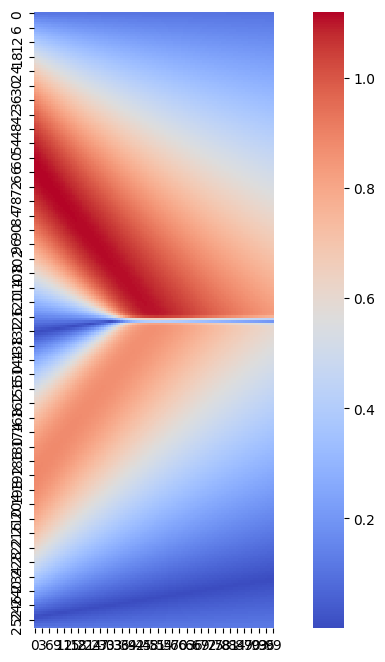

In [8]:

#Load hyperparameters from YAML file
with open("hyperparameters.yml", "r") as file:
    config = yaml.safe_load(file)
hyperparams = config["hyperparameters"]

#Create dropdown widgets for user selection
layers_dropdown = widgets.Dropdown(options=hyperparams["layers"], description="Layers:")
neurons_dropdown = widgets.Dropdown(options=hyperparams["neurons"], description="Neurons:")
samples_dropdown = widgets.Dropdown(options=hyperparams["training_samples"], description="Samples:")
noise_dropdown = widgets.Dropdown(options=hyperparams["noise_level"], description="Noise:")
iterations_dropdown = widgets.Dropdown(options=hyperparams["iterations"], description="Iterations:")
run_button = widgets.Button(description="Run Experiment")
output = widgets.Output()

#Define function to run the experiment
def run_experiment(layers, neurons, samples, noise, iterations):
    with output:
        output.clear_output()
        print(f"Running experiment with Layers={layers}, Neurons={neurons}, Samples={samples}, Noise={noise}, Iterations={iterations}")

        # Load data
        data = get_data()
        x_test, y_test, *_ = data

        # Start timing
        start_time = time.time()
        PINN_experiment(data, [noise], verbose=False, rerun=True)
        end_time = time.time()

        # Load RMSE from saved results instead of recalculating
        all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
        rmse = all_results[0][-1]  # Extract the last stored RMSE

        print(f"\nResults:")
        print(f" - Loaded RMSE from training: {rmse:.6f}")
        print(f" - Running Time: {end_time - start_time:.2f} seconds")

        # Generate contour plots for actual vs predicted solutions
        model = Model()
        x_test_tensor = torch.tensor(x_test).double()
        predictions = model.forward(x_test_tensor).detach().numpy()

        x_values = np.unique([x[0] for x in x_test])
        t_values = np.unique([x[1] for x in x_test])
        Y_actual = np.array(y_test).reshape(len(t_values), len(x_values))
        Y_pred = predictions.reshape(len(t_values), len(x_values))

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        c1 = ax[0].contourf(t_values, x_values, Y_actual.T, cmap="coolwarm", levels=50)
        fig.colorbar(c1, ax=ax[0])
        ax[0].set_title("Burgers' Solution $u(t,x)$")
        ax[0].set_xlabel("t (s)")
        ax[0].set_ylabel("x")

        c2 = ax[1].contourf(t_values, x_values, Y_pred.T, cmap="coolwarm", levels=50)
        fig.colorbar(c2, ax=ax[1])
        ax[1].set_title("Predicted $\\hat{u}(t,x)$")
        ax[1].set_xlabel("t (s)")
        ax[1].set_ylabel("x")

        plt.tight_layout()
        plt.show()

        # Generate heatmap of error
        error = np.abs(Y_actual - Y_pred)
        error = np.nan_to_num(error, nan=0.0, posinf=np.max(error[np.isfinite(error)]), neginf=0.0)

        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(error.T, cmap="coolwarm", cbar=True, square=True)

        num_x_ticks = 10  
        num_t_ticks = 10  

        ax.set_xticks(np.linspace(0, len(t_values) - 1, num_t_ticks))  
        ax.set_xticklabels(np.round(np.linspace(t_values.min(), t_values.max(), num_t_ticks), 2)) 

        ax.set_yticks(np.linspace(0, len(x_values) - 1, num_x_ticks))
        ax.set_yticklabels(np.round(np.linspace(x_values.min(), x_values.max(), num_x_ticks), 2)) 

        plt.xlabel("t (s)")
        plt.ylabel("x")
        plt.title("Heatmap of Prediction Error")
        plt.show()

# Define button click function
def on_button_click(b):
    run_experiment(layers_dropdown.value, neurons_dropdown.value, samples_dropdown.value, noise_dropdown.value, iterations_dropdown.value)

# Bind button to function
run_button.on_click(on_button_click)

# Display UI components
display(widgets.VBox([layers_dropdown, neurons_dropdown, samples_dropdown, noise_dropdown, iterations_dropdown, run_button, output]))